In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [79]:
nside = 64
mission_time_is_sec = 24 * 3600 * 10 # 200 if you want to make a map
instrument = "MFT"
channel = "M1-140"
sampling = 1  # this replaces channelinfo.sampling_rate_hz

In [80]:
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="./tutorial",
    start_time=0,
    duration_s=mission_time_is_sec,
)

In [81]:
mft_file = sim.imo.query("/releases/v1.3/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(
    imo_url="/releases/v1.3/satellite/scanning_parameters/"
)

instrumentinfo = lbs.InstrumentInfo.from_imo(
    imo, f"/releases/v1.3/satellite/{instrument}/instrument_info"
)

#instrumentinfo = lbs.InstrumentInfo(
#    name=instrument,
#    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
#    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
#    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
#)
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.3/satellite/" + instrument + "/" + channel + "/channel_info",
    imo=imo,
)
hwp_radpsec = lbs.IdealHWP(instrumentinfo.hwp_rpm * 2 * np.pi / 60,).ang_speed_radpsec

[2022-10-26 10:49:04,765 WARNING MPI#0000] Band is not apodized


In [82]:
dets = []
detquats = []
# for detname in channelinfo.detector_names[0:20]:
for detname in (
    "001_003_030_00A_140_T", 
    "001_003_030_00A_140_B"
   # "M03_030_QA_100T",
   # "M03_030_QA_100B",
):  # we choose the couple of detector at the MFT boresight
    det = lbs.DetectorInfo.from_imo(
        url="/releases/v1.3/satellite/"
        + instrument
        + "/"
        + channel
        + "/"
        + detname
        + "/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

[2022-10-26 10:49:04,777 WARNING MPI#0000] Band is not apodized
[2022-10-26 10:49:04,780 WARNING MPI#0000] Band is not apodized


## Create file with HWP non-ideal parameters for MFT
#### The files 'M/HFT_Mesh_HWP_v2.txt' are given from the simulated HWP profiles at https://wiki.kek.jp/download/attachments/123338913/2019_06_22_MFT_HFT_HWP_GP_to_LB_team.xlsx?version=1&modificationDate=1585750021431&api=v2. We read the MFT one to convert the parameters in the way defined in Giardiello et al.

In [6]:
mft = np.loadtxt("MFT_Mesh_HWP_v2.txt")

nu = mft[:, 0]
h1 = np.sqrt(mft[:, 1]) - 1.0
h2 = np.sqrt(mft[:, 3]) - 1.0
beta = mft[:, 5] - 180.0
z1 = 0.01 * np.ones_like(nu)
z2 = 0.01 * np.ones_like(nu)

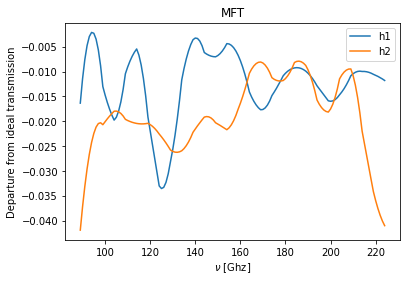

In [13]:
plt.plot(nu, h1, label="h1")
plt.plot(nu, h2, label="h2")
plt.xlabel(r"$\nu$ [Ghz]")
plt.ylabel("Departure from ideal transmission")
plt.title("MFT")
plt.legend()

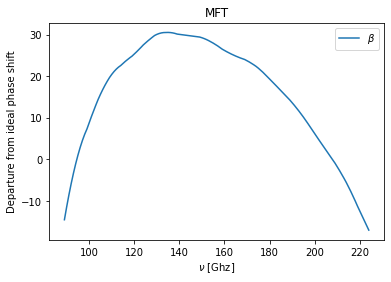

In [14]:
plt.plot(nu, beta, label=r"$\beta$")
plt.xlabel(r"$\nu$ [Ghz]")
plt.ylabel("Departure from ideal phase shift")
plt.title("MFT")
plt.legend()

for the purpose of this exercise, let's focus on the frequencies of the 100 GHz band (89,111)

In [7]:
i_i = np.where(nu == 119-22)[0][0]
i_f = np.where(nu == 161+23)[0][0]
Nu = nu[i_i:i_f]
H1 = h1[i_i:i_f]
H2 = h2[i_i:i_f]
Beta = beta[i_i:i_f]
Z1 = z1[i_i:i_f]
Z2 = z2[i_i:i_f]

In [8]:
np.savetxt("MFT_140_h_beta_z_wider.txt", np.column_stack((Nu, H1, H2, Beta, Z1, Z2)),
           header = '# nu   h1   h2   beta   z1   z2')

#### let's build a top-hat bandpass

In [8]:
from litebird_sim import BandPassInfo

In [9]:
B0 = BandPassInfo(
        bandcenter_ghz= 140,
        bandwidth_ghz=42,
        bandlow_ghz = Nu[0],
        bandhigh_ghz = Nu[-1],
        nsamples_inband=Nu.size,
        name="top-hat ",
    )

[2022-10-26 10:18:09,414 WARNING MPI#0000] Band is not apodized


In [10]:
B0.freqs_ghz

array([ 97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
       108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160., 161., 162.,
       163., 164., 165., 166., 167., 168., 169., 170., 171., 172., 173.,
       174., 175., 176., 177., 178., 179., 180., 181., 182., 183.])

In [11]:
B0.get_edges()

(119.0, 161.0)

In [12]:
B0.freqs_ghz[np.where(B0.weights == 1)[0]]

array([119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160., 161.])

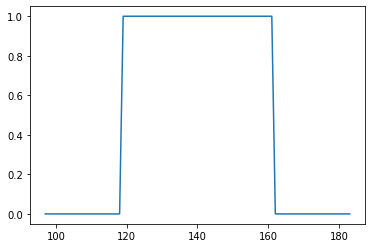

In [13]:
plt.plot(B0.freqs_ghz,B0.weights)

for a bandpass with exponentially decaying wings:

In [14]:
Bexp = BandPassInfo(
        bandcenter_ghz= 140,
        bandwidth_ghz=42,
        bandlow_ghz = Nu[0],
        bandhigh_ghz = Nu[-1],
        nsamples_inband=Nu.size,
        bandtype="top-hat-exp",
        normalize=False,
       alpha_exp = 0.9,
       beta_exp = 0.9
    )

[2022-10-25 15:59:05,361 WARNING MPI#0000] Apodizing w/ exp profile


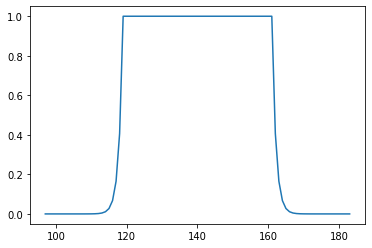

In [15]:
plt.plot(Bexp.freqs_ghz, Bexp.weights)

for a bandpass with cosine apodization


In [16]:
Bcos = BandPassInfo(
        bandcenter_ghz= 140,
        bandwidth_ghz=42,
        bandlow_ghz = Nu[0],
        bandhigh_ghz = Nu[-1],
        nsamples_inband=Nu.size,
        bandtype="top-hat-cosine",
        normalize=False,
       cosine_apo_length =2
    )

[2022-10-25 15:59:07,534 WARNING MPI#0000] Apodizing w/ cosine profile


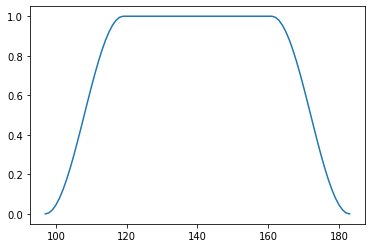

In [17]:
plt.plot(Bcos.freqs_ghz, Bcos.weights)

## Fill tod with a band top-hat + wings

In [67]:
(obs_w,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

In [72]:
(pointings,) = lbs.get_pointings_for_observations(
    sim.observations,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    bore2spin_quat=instrumentinfo.bore2spin_quat,
    hwp= None,
    #lbs.IdealHWP(
    #    inst_info.hwp_rpm * 2 * np.pi / 60,
    #),  # applies hwp rotation angle to the polarization angle
    store_pointings_in_obs=True,  # if True, stores colatitude and longitude in
    # sim.observations[:].pointings, and the polarization angle in
    # sim.observations[:].psi
)

if you are using band integration (`integrate_in_band = True` in `hwp_sys.set_parameters`) you don't need to create a map beforehand, the `set_parameters` function of HwpSys will generate one cmb+fg map for each frequency. The following cell is commented because it is not needed when using band integration

In [12]:
# Mbsparams = lbs.MbsParameters(make_cmb =True,
#                              make_fg = False,
#                              gaussian_smooth = True,
#                              bandpass_int = False,
#                              nside = nside,
#                             )

# mbs = lbs.Mbs(simulation=sim,
#              parameters=Mbsparams,
#              channel_list=channelinfo,
#             )
# maps = mbs.run_all()[0][channel]

[2021-12-30 12:21:37,845 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 12:21:37,863 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,077 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:38,077 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 12:21:38,960 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,963 INFO MPI#0000] NSIDE = 512
[2021-12-30 12:21:38,963 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 12:21:38,964 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2021-12-30 12:21:39,725 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:44,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2021-12-30 12:21:44,632 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2021-12-30 12:21:44,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:44,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [51]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat-exp",
            "band_alpha": 0.9,
            "band_beta": 0.9,
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [52]:
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

Let's initialise Mbsparams in order to set a seed for the cmb map. The FG is always the same

In [53]:
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=["pysm_synch_1", "pysm_freefree_1", "pysm_dust_1", "pysm_ame_1"],
    bandpass_int=False,
    maps_in_ecliptic=False,
    gaussian_smooth = True,
    seed_cmb=1234,
    nside=nside,
)

the next command will take a while with band integration, since it has to generate one map per frequency

In [54]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    integrate_in_band_solver=True,
    correct_in_solver=True,
    built_map_on_the_fly=False,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-26 10:39:38,024 WARNING MPI#0000] Apodizing w/ exp profile
[2022-10-26 10:39:38,026 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-26 10:39:38,027 INFO MPI#0000] generating and saving cmb simulations
[2022-10-26 10:39:38,041 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:38,041 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:38,054 INFO MPI#0000] NSIDE = 64
[2022-10-26 10:39:38,061 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:39:38,062 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 10:39:38,133 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:38,134 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:38,135 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:38,136 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:38,180 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:38,181 INFO MPI#0000] -> fwhm is 30.800000 

***************** D
***************** D
***************** D


[2022-10-26 10:39:38,281 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:38,282 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:38,283 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:38,283 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:38,342 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:38,342 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:38,343 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:38,344 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:38,398 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:38,399 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:38,400 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:38,401 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:38,454 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:38,455

[2022-10-26 10:39:39,806 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:39,807 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:39,843 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:39,844 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:39,845 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:39,846 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:39,883 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:39,884 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:39,886 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:39,886 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:39,920 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:39,921 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:39,922 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:39,923 

[2022-10-26 10:39:40,975 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:40,976 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:40,977 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:40,978 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:41,015 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:41,016 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:41,018 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:41,018 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:41,056 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:41,057 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:41,058 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:41,059 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:41,101 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:41,101

[2022-10-26 10:39:42,105 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:42,107 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:42,146 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:42,148 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:42,150 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:42,152 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:42,233 INFO MPI#0000] generating and saving fg simulations
[2022-10-26 10:39:42,237 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:39:42,239 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:39:42,241 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 10:39:42,359 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:39:42,361 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:39:42,363 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 10:39:42,484 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:39:42,486 INFO MPI#0000] ORDERING = RING in fits

[2022-10-26 10:39:46,759 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:46,761 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:46,947 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:46,948 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:46,949 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:46,950 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:47,138 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:47,139 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:47,142 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:47,142 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:47,359 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:47,359 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:47,362 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:47,370 

[2022-10-26 10:39:51,510 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:51,516 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:51,520 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:51,526 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:51,681 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:51,683 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:51,685 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:51,687 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:51,848 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:51,850 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:51,853 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:51,855 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:52,002 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:52,004

[2022-10-26 10:39:56,058 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:56,060 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:56,213 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:56,218 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:56,221 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:56,223 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:56,383 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:56,385 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:56,387 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:56,389 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:56,547 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:56,549 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:56,551 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:56,553 

[2022-10-26 10:39:59,906 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:59,908 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:00,015 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:00,021 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:00,024 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:00,026 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:00,163 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:00,165 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:00,168 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:00,170 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:00,264 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:00,266 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:00,268 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:00,270 

[2022-10-26 10:40:03,219 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:03,221 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:03,224 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:03,226 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:03,332 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:03,334 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:03,336 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:03,338 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:03,444 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:03,446 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:03,448 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:03,451 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:03,554 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:03,556

[2022-10-26 10:40:06,208 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:06,210 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:06,319 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:06,321 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:06,323 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:06,325 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:06,429 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:06,431 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:06,433 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:06,435 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:06,536 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:06,538 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:06,540 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:06,542 

[2022-10-26 10:40:11,587 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:11,589 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:11,592 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:11,593 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:11,854 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:11,856 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:11,858 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:11,860 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:12,114 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:12,116 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:12,119 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:12,120 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:12,375 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:12,377

[2022-10-26 10:40:18,687 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:18,689 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:18,951 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:18,953 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:18,956 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:18,958 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:19,206 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:19,208 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:19,210 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:19,212 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:19,446 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:19,448 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:19,451 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:19,452 

[2022-10-26 10:40:26,422 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:26,424 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:26,426 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:26,428 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:26,669 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:26,671 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:26,673 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:26,675 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:26,930 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:26,931 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:26,934 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:26,936 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:27,168 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:27,169

[2022-10-26 10:40:32,991 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:33,155 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:33,157 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:33,160 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:33,162 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:33,329 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:33,331 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:33,333 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:33,336 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:33,504 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:33,506 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:33,508 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:33,510 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:33,663 INFO MPI#0000]

[2022-10-26 10:40:37,749 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:37,751 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:37,753 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:37,903 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:37,905 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:37,907 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:37,909 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:38,089 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:38,091 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:38,093 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:38,095 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:38,259 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:38,261 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:38,263 INFO MPI#0000

[2022-10-26 10:40:42,291 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:42,355 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:42,361 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:42,364 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:42,367 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:42,431 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:42,438 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:42,441 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:42,443 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:42,608 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:40:42,611 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:40:42,613 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:40:42,616 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:40:42,782 INFO MPI#0000]

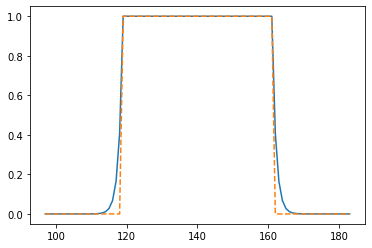

In [14]:
plt.plot(hwp_sys_band.freqs,hwp_sys_band.bandpass_profile, label = 'tod')
plt.plot(hwp_sys_band.freqs,hwp_sys_band.bandpass_profile_solver, ls = '--', label = 'solver')

In [55]:
t_in = time.time()
hwp_sys_band.fill_tod(obs = obs_w, pointings = pointings, 
                      hwp_radpsec = hwp_radpsec)
t_tod = time.time()
t_tod - t_in
# obs.tod *= 2.0  #this 2 factor is useful only when comparing to the mapmaking in lbs.make_bin_map
# for which the tod is twice as the one computed here

9.910930395126343

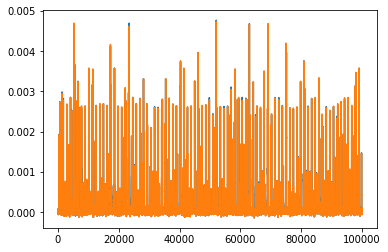

In [56]:
plt.plot(obs_w.tod[0, :100000])
plt.plot(obs_w.tod[1, :100000])

since we have few days of observation, it is pointless to generate a map

# Testing out_of_band_analysis against hwp_sys

Let's take now a top-hat band. Let's consider the actual 140 GHz one, in order to compare the result coming from out_of_band_analysis.py to the top-hat band that hwp_sys.py would consider by reading the frequencies in the parameter file `MFT_140_h_beta_z_wider.txt`

we generate a clean observation each time we want to compute a new tod

In [20]:
(obs,) = sim.create_observations(detectors=dets)

In [24]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat",
            "band_low_edge": Nu[0],
            "band_high_edge": Nu[-1],
            "bandcenter_ghz": channelinfo.bandcenter_ghz,            
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": Nu[0],
            "band_high_edge": Nu[-1],
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [25]:
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [26]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    integrate_in_band_solver=True,
    correct_in_solver=True,
    built_map_on_the_fly=False,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-25 17:57:48,696 WARNING MPI#0000] Band is not apodized
[2022-10-25 17:57:48,698 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-25 17:57:48,699 INFO MPI#0000] generating and saving cmb simulations
[2022-10-25 17:57:48,709 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:48,710 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221025.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-25 17:57:48,742 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-25 17:57:48,744 INFO MPI#0000] NSIDE = 64
[2022-10-25 17:57:48,745 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-25 17:57:48,745 INFO MPI#0000] INDXSCHM =

***************** D
***************** D
***************** D


[2022-10-25 17:57:48,932 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:48,932 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:48,934 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:48,934 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:48,971 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:48,971 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:48,973 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:48,973 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:49,015 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:49,015 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:49,016 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:49,017 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:49,051 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:49,052

[2022-10-25 17:57:50,178 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:50,179 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:50,214 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:50,217 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:50,219 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:50,221 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:50,258 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:50,260 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:50,263 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:50,265 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:50,302 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:50,304 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:50,306 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:50,308 

[2022-10-25 17:57:51,440 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:51,442 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:51,444 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:51,446 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:51,490 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:51,491 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:51,493 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:51,495 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:51,534 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:51,536 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:51,538 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:51,539 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:51,575 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:51,577

[2022-10-25 17:57:52,705 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:52,706 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:52,745 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:52,747 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:52,749 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:52,751 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:52,837 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-25 17:57:52,841 INFO MPI#0000] NSIDE = 512
[2022-10-25 17:57:52,843 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-25 17:57:52,847 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-25 17:57:56,850 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:56,852 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:56,854 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:57,042 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:57,044 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:57,046 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:57,048 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:57,224 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:57,226 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:57,228 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:57:57,230 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:57:57,411 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:57:57,413 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:57:57,415 INFO MPI#0000

[2022-10-25 17:58:01,739 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:01,881 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:01,883 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:01,886 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:01,890 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:02,042 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:02,044 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:02,047 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:02,050 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:02,197 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:02,203 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:02,210 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:02,213 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:02,353 INFO MPI#0000]

[2022-10-25 17:58:06,377 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:06,380 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:06,382 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:06,543 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:06,545 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:06,548 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:06,550 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:06,712 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:06,714 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:06,717 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:06,721 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:06,894 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:06,896 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:06,898 INFO MPI#0000

[2022-10-25 17:58:10,208 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:10,210 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:10,321 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:10,323 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:10,326 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:10,329 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:10,439 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:10,441 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:10,444 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:10,446 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:10,568 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:10,574 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:10,578 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:10,580 

[2022-10-25 17:58:13,317 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:13,319 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:13,321 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:13,325 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:13,437 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:13,439 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:13,441 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:13,445 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:13,541 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:13,543 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:13,546 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:13,549 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:13,657 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:13,659

[2022-10-25 17:58:16,451 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:16,453 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:16,557 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:16,559 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:16,561 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:16,563 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:16,665 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:16,667 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:16,669 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:16,671 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:16,763 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:16,765 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:16,767 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:16,769 

[2022-10-25 17:58:19,938 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:19,940 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:19,943 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:19,945 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:20,194 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:20,196 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:20,198 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:20,200 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:20,458 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:20,460 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:20,463 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:20,466 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:20,727 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:20,733

[2022-10-25 17:58:27,142 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:27,144 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:27,375 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:27,376 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:27,379 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:27,381 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:27,684 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:27,686 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:27,689 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:27,690 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:28,007 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:28,009 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:28,011 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:28,013 

[2022-10-25 17:58:34,603 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:34,605 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:34,608 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:34,610 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:34,863 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:34,865 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:34,867 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:34,870 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:35,141 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:35,142 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:35,145 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:35,147 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:35,369 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:35,375

[2022-10-25 17:58:40,919 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:40,920 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:41,191 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:41,193 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:41,195 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:41,197 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-25 17:58:41,210 INFO MPI#0000] NSIDE = 512
[2022-10-25 17:58:41,212 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-25 17:58:41,214 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_n

[2022-10-25 17:58:44,981 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:44,989 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:44,992 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:44,995 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:45,055 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:45,063 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:45,066 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:45,068 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:45,253 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:45,260 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:45,263 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:45,265 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:45,429 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:45,431

[2022-10-25 17:58:47,855 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:47,856 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:48,015 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:48,017 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:48,019 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:48,021 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:48,203 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:48,205 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:48,207 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:48,209 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:48,384 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:48,386 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:48,388 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:48,390 

[2022-10-25 17:58:52,067 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:52,067 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:52,069 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:52,078 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:52,281 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:52,282 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:52,285 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:52,285 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:52,500 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:52,509 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 17:58:52,512 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 17:58:52,515 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 17:58:52,683 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 17:58:52,685

In [30]:
hwp_sys_band.fill_tod(obs = obs, hwp_radpsec=hwp_radpsec, pointings=pointings)

In [31]:
obs.tod

array([[ 4.3422588e-05,  4.3879903e-05,  4.3261851e-05, ...,
        -4.0188093e-05, -3.9532402e-05,  4.7438269e-05],
       [ 4.3893335e-05,  4.3273554e-05,  4.3479700e-05, ...,
        -3.9604500e-05, -3.9958017e-05,  4.7266440e-05]], dtype=float32)

let's create a new simulation, initialise hwp_sys and compute the same kind of tod

In [32]:
sim1 = lbs.Simulation(
    base_path="./tutorial",
    start_time=0,
    duration_s=mission_time_is_sec,
)

In [34]:
mft_file = sim1.imo.query("/releases/v1.3/satellite/" + instrument + "/instrument_info")
sim1.generate_spin2ecl_quaternions(
    imo_url="/releases/v1.3/satellite/scanning_parameters/"
)

In [35]:
(obs1,) = sim1.create_observations(detectors=dets)

In [36]:
sim1.parameter_file = par
hwp_sys = lbs.HwpSys(sim1)

In [37]:
hwp_sys.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    integrate_in_band_solver=True,
    correct_in_solver=True,
    built_map_on_the_fly=False,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-25 18:01:07,667 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-25 18:01:07,668 INFO MPI#0000] generating and saving cmb simulations
[2022-10-25 18:01:07,678 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:07,678 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221025.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-25 18:01:07,698 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-25 18:01:07,701 INFO MPI#0000] NSIDE = 64
[2022-10-25 18:01:07,701 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-25 18:01:07,701 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-25 18:01:07,753 INFO MPI#0000] Sigma is 13.07

***************** D
***************** D
***************** D


[2022-10-25 18:01:07,896 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:07,897 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:07,898 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:07,898 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:07,936 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:07,936 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:07,938 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:07,938 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:07,971 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:07,972 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:07,973 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:07,974 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:08,008 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:08,009

[2022-10-25 18:01:09,021 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:09,022 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:09,064 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:09,065 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:09,067 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:09,067 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:09,102 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:09,103 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:09,104 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:09,105 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:09,137 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:09,138 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:09,140 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:09,140 

[2022-10-25 18:01:10,250 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:10,252 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:10,254 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:10,256 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:10,291 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:10,293 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:10,295 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:10,296 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:10,330 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:10,332 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:10,334 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:10,336 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:10,367 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:10,369

[2022-10-25 18:01:11,586 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:11,588 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:11,627 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:11,629 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:11,632 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:11,634 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:11,728 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-25 18:01:11,733 INFO MPI#0000] NSIDE = 512
[2022-10-25 18:01:11,735 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-25 18:01:11,737 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-25 18:01:16,657 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:16,662 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:16,665 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:16,832 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:16,834 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:16,837 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:16,838 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:16,998 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:17,000 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:17,004 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:17,005 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:17,178 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:17,181 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:17,183 INFO MPI#0000

[2022-10-25 18:01:21,559 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:21,727 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:21,729 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:21,731 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:21,733 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:21,937 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:21,939 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:21,941 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:21,943 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:22,141 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:22,143 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:22,145 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:22,147 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:22,306 INFO MPI#0000]

[2022-10-25 18:01:26,473 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:26,474 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:26,475 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:26,648 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:26,649 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:26,651 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:26,651 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:26,813 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:26,814 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:26,815 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:26,816 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:27,070 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:27,078 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:27,090 INFO MPI#0000

[2022-10-25 18:01:30,451 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:30,452 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:30,569 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:30,571 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:30,573 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:30,575 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:30,677 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:30,679 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:30,681 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:30,683 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:30,798 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:30,800 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:30,802 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:30,804 

[2022-10-25 18:01:33,670 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:33,672 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:33,675 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:33,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:33,786 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:33,788 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:33,790 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:33,792 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:33,904 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:33,905 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:33,908 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:33,909 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:34,019 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:34,021

[2022-10-25 18:01:36,734 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:36,736 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:36,848 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:36,850 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:36,852 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:36,854 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:36,955 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:36,957 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:36,959 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:36,961 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:37,062 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:37,064 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:37,066 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:37,068 

[2022-10-25 18:01:40,247 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:40,249 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:40,251 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:40,253 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:40,494 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:40,496 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:40,498 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:40,500 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:40,746 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:40,748 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:40,751 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:40,752 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:41,003 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:41,005

[2022-10-25 18:01:47,226 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:47,229 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:47,464 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:47,466 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:47,469 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:47,471 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:47,737 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:47,739 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:47,742 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:47,744 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:47,986 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:47,988 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:47,991 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:47,993 

[2022-10-25 18:01:54,917 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:54,919 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:54,922 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:54,925 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:55,228 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:55,229 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:55,233 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:55,235 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:55,626 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:55,628 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:01:55,630 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:01:55,632 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:01:55,995 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:01:55,995

[2022-10-25 18:02:02,390 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:02,391 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:02,644 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:02,645 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:02,646 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:02,647 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-25 18:02:02,659 INFO MPI#0000] NSIDE = 512
[2022-10-25 18:02:02,659 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-25 18:02:02,660 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_n

[2022-10-25 18:02:07,096 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:07,098 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:07,100 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:07,102 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:07,273 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:07,275 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:07,277 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:07,279 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:07,452 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:07,454 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:07,456 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:07,458 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:07,626 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:07,628

[2022-10-25 18:02:11,858 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:11,860 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:12,018 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:12,020 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:12,022 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:12,024 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:12,198 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:12,200 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:12,202 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:12,204 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:12,369 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:12,371 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:12,373 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:12,375 

[2022-10-25 18:02:17,017 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:17,019 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:17,021 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:17,023 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:17,190 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:17,192 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:17,195 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:17,196 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:17,338 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:17,340 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-25 18:02:17,342 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-25 18:02:17,344 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-25 18:02:17,506 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-25 18:02:17,514

we see that the maps generated by the two classes are exactly the same

In [38]:
(hwp_sys.maps == hwp_sys_band.maps).all()

True

In [40]:
hwp_sys.fill_tod(obs1, pointings[0], hwp_radpsec)

The bands are the same

In [41]:
hwp_sys.cmb2bb / hwp_sys.norm == hwp_sys_band.cmb2bb

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [42]:
obs1.tod - obs.tod

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
(obs.tod == obs1.tod).all()

True

the two tod are exactly the same when we set `include_beam_throughput=False` in `hwp_sys_band.set_parameters`

## Introducing a shift to the bands

We can set the steps for generating tods including bands that have some shifts (we can both set a rigid shift of the two ends of the band and shift them differently). 
For how the bandpasses are built, even if we apply a different shift at the two ends of the band, it will be always centered at the selected `bandcenter_ghz`.

[2022-10-26 10:31:52,031 WARNING MPI#0000] Band is not apodized
[2022-10-26 10:31:52,033 WARNING MPI#0000] Band is not apodized


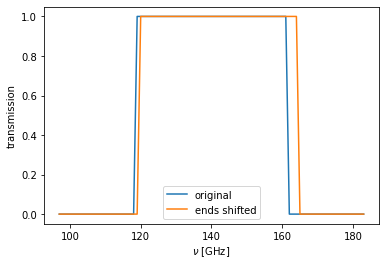

In [31]:
shift_low = 1  # needed resolution of 1 GHz since this is the present resolution on HWP parameters
shift_high = 3
shift_center = 2

bandpass_parameters = {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        }

bandpass_parameters_sh = {
            "band_type": "top-hat",
            "band_low_edge": 119 + shift_low,
            "band_high_edge": 161 + shift_high,
            "bandcenter_ghz": channelinfo.bandcenter_ghz+shift_center,
        }

transmission = lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(
    Nu, bandpass_parameters
)

transmission_shifted = (
    lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(
        Nu, bandpass_parameters_sh
    )
)
plt.plot(transmission[0], transmission[1], label="original")
plt.plot(transmission_shifted[0], transmission_shifted[1], label="ends shifted")
plt.xlabel(r"$\nu$ [GHz]")
plt.ylabel("transmission")
plt.legend()

In [44]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat-exp",
            "band_alpha": 0.9,
            "band_beta": 0.9,
            "band_low_edge": 119 + shift_low,
            "band_high_edge": 161 + shift_high,
            "bandcenter_ghz": channelinfo.bandcenter_ghz + shift_center,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [45]:
(obs_sh,) = sim.create_observations(detectors=dets)
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [46]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    integrate_in_band_solver=True,
    correct_in_solver=True,
    built_map_on_the_fly=False,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-26 10:38:22,051 WARNING MPI#0000] Apodizing w/ exp profile
[2022-10-26 10:38:22,053 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-26 10:38:22,054 INFO MPI#0000] generating and saving cmb simulations
[2022-10-26 10:38:22,069 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:22,070 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221026.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-26 10:38:22,092 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-26 10:38:22,095 INFO MPI#0000] NSIDE = 64
[2022-10-26 10:38:22,095 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:38:22,096 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


[2022-10-26 10:38:22,292 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:22,292 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:22,294 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:22,294 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:22,341 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:22,342 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:22,343 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:22,343 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:22,402 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:22,403 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:22,404 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:22,404 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:22,450 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:22,451

[2022-10-26 10:38:23,549 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:23,550 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:23,593 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:23,594 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:23,595 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:23,595 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:23,629 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:23,630 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:23,631 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:23,632 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:23,672 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:23,673 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:23,674 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:23,675 

[2022-10-26 10:38:24,825 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:24,826 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:24,827 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:24,828 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:24,860 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:24,861 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:24,863 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:24,863 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:24,899 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:24,900 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:24,901 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:24,902 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:24,939 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:24,941

[2022-10-26 10:38:26,076 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:26,081 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:26,114 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:26,115 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:26,118 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:26,122 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:26,213 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-26 10:38:26,217 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:38:26,221 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:38:26,223 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-26 10:38:30,776 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:30,778 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:30,779 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:30,983 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:30,985 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:30,988 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:30,990 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:31,191 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:31,193 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:31,195 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:31,197 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:31,451 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:31,453 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:31,456 INFO MPI#0000

[2022-10-26 10:38:36,118 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:36,284 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:36,286 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:36,289 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:36,292 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:36,351 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:36,353 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:36,355 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:36,357 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:36,403 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:36,405 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:36,407 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:36,409 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:36,455 INFO MPI#0000]

[2022-10-26 10:38:40,478 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:40,480 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:40,482 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:40,648 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:40,650 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:40,653 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:40,654 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:40,824 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:40,826 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:40,828 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:40,830 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:40,999 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:41,001 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:41,003 INFO MPI#0000

[2022-10-26 10:38:44,297 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:44,300 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:44,394 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:44,401 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:44,404 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:44,406 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:44,526 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:44,528 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:44,531 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:44,533 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:44,653 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:44,655 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:44,657 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:44,659 

[2022-10-26 10:38:47,564 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:47,566 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:47,569 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:47,570 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:47,703 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:47,705 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:47,707 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:47,709 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:47,761 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:47,762 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:47,766 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:47,768 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:47,907 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:47,909

[2022-10-26 10:38:50,293 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:50,302 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:50,428 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:50,429 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:50,434 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:50,442 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:50,544 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:50,545 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:50,546 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:50,546 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:50,656 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:50,657 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:50,658 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:50,665 

[2022-10-26 10:38:53,853 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:53,855 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:53,857 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:53,859 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:54,104 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:54,106 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:54,109 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:54,111 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:54,372 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:54,374 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:38:54,376 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:38:54,379 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:38:54,639 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:38:54,641

[2022-10-26 10:39:01,095 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:01,095 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:01,347 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:01,349 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:01,351 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:01,353 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:01,595 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:01,597 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:01,600 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:01,602 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:01,837 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:01,839 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:01,842 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:01,843 

[2022-10-26 10:39:06,743 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:06,744 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:06,745 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:06,746 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:06,809 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:06,810 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:06,812 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:06,812 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:06,876 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:06,877 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:06,878 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:06,879 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:06,944 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:06,945

[2022-10-26 10:39:11,917 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:11,919 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:12,157 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:12,162 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:12,165 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:12,167 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-26 10:39:12,174 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:39:12,176 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:39:12,178 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_n

[2022-10-26 10:39:15,823 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:15,825 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:15,827 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:15,830 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:15,994 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:16,001 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:16,008 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:16,010 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:16,173 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:16,176 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:16,178 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:16,180 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:16,358 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:16,360

[2022-10-26 10:39:20,444 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:20,445 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:20,605 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:20,607 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:20,610 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:20,612 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:20,775 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:20,777 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:20,779 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:20,781 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:20,964 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:20,966 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:20,969 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:20,971 

[2022-10-26 10:39:25,913 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:25,915 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:25,917 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:25,919 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:26,066 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:26,068 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:26,071 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:26,074 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:26,228 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:26,230 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:39:26,232 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:39:26,234 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:39:26,391 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:39:26,393

In [47]:
hwp_sys_band.fill_tod(obs = obs_sh, pointings = pointings, hwp_radpsec = hwp_radpsec)

let's compare the tod produced with shifts to the 'normal' one

Text(0, 0.5, 'tod w/ shifts - tod w/o shifts')

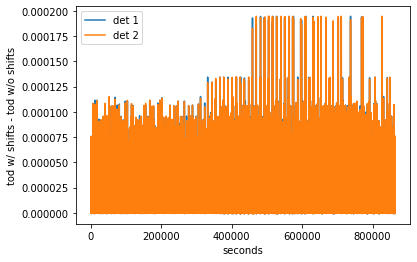

In [61]:
plt.plot(obs_sh.tod[0] - obs_w.tod[0], label="det 1")
plt.plot(obs_sh.tod[1] - obs_w.tod[1], label="det 2")
plt.legend()
plt.xlabel("seconds")
plt.ylabel("tod w/ shifts - tod w/o shifts")

There is overall a ~ percent difference between the two. The difference is due to the foregrounds, which are frequency dependent, and the interplay with chromatic HWP non-idealities

## To make a map

before doing that, let's increase `mission_time_days` to 200 and execute again the first cells

In [85]:
(obs,) = sim.create_observations(detectors=dets)

(pointings,) = lbs.get_pointings_for_observations(
    sim.observations,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    bore2spin_quat=instrumentinfo.bore2spin_quat,
    hwp= None,
    #lbs.IdealHWP(
    #    inst_info.hwp_rpm * 2 * np.pi / 60,
    #),  # applies hwp rotation angle to the polarization angle
    store_pointings_in_obs=True,  # if True, stores colatitude and longitude in
    # sim.observations[:].pointings, and the polarization angle in
    # sim.observations[:].psi
)

In [86]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [87]:
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [88]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    correct_in_solver=True,
    integrate_in_band_solver=True,
    built_map_on_the_fly=True,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-26 10:51:08,145 WARNING MPI#0000] Band is not apodized
[2022-10-26 10:51:08,147 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-26 10:51:08,148 INFO MPI#0000] generating and saving cmb simulations
[2022-10-26 10:51:08,160 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:08,161 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:08,187 INFO MPI#0000] NSIDE = 64
[2022-10-26 10:51:08,188 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:51:08,188 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 10:51:08,234 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:08,234 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:08,236 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:08,238 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:08,293 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:08,294 INFO MPI#0000] -> fwhm is 30.800000 arcm

***************** D
***************** D
***************** D


[2022-10-26 10:51:08,400 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:08,401 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:08,402 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:08,403 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:08,461 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:08,462 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:08,463 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:08,464 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:08,511 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:08,512 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:08,514 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:08,514 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:08,561 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:08,561

[2022-10-26 10:51:09,722 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:09,723 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:09,762 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:09,763 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:09,764 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:09,765 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:09,809 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:09,810 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:09,811 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:09,812 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:09,853 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:09,854 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:09,856 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:09,856 

[2022-10-26 10:51:11,182 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:11,183 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:11,184 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:11,185 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:11,227 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:11,228 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:11,229 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:11,230 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:11,263 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:11,265 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:11,266 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:11,267 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:11,305 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:11,306

[2022-10-26 10:51:12,313 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:12,314 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:12,352 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:12,353 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:12,354 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:12,355 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:12,445 INFO MPI#0000] generating and saving fg simulations
[2022-10-26 10:51:12,448 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:51:12,449 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:51:12,450 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 10:51:12,566 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:51:12,566 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 10:51:12,567 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 10:51:12,685 INFO MPI#0000] NSIDE = 512
[2022-10-26 10:51:12,685 INFO MPI#0000] ORDERING = RING in fits

[2022-10-26 10:51:17,313 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:17,315 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:17,505 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:17,511 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:17,514 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:17,516 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:17,669 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:17,671 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:17,674 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:17,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:17,839 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:17,842 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:17,844 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:17,847 

[2022-10-26 10:51:22,277 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:22,277 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:22,279 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:22,279 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:22,514 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:22,516 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:22,519 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:22,521 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:22,672 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:22,683 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:22,686 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:22,688 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:22,828 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:22,830

[2022-10-26 10:51:27,106 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:27,107 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:27,272 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:27,273 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:27,274 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:27,275 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:27,457 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:27,458 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:27,459 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:27,460 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:27,624 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:27,625 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:27,626 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:27,627 

[2022-10-26 10:51:30,791 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:30,793 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:30,897 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:30,899 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:30,901 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:30,903 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:31,015 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:31,017 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:31,019 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:31,020 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:31,129 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:31,131 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:31,133 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:31,135 

[2022-10-26 10:51:34,104 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:34,106 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:34,108 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:34,110 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:34,225 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:34,227 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:34,230 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:34,231 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:34,351 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:34,352 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:34,355 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:34,357 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:34,477 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:34,479

[2022-10-26 10:51:37,358 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:37,360 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:37,469 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:37,470 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:37,473 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:37,475 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:37,582 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:37,584 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:37,586 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:37,588 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:37,700 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:37,701 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:37,704 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:37,705 

[2022-10-26 10:51:42,677 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:42,679 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:42,681 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:42,683 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:42,936 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:42,938 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:42,940 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:42,942 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:43,189 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:43,191 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:43,194 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:43,196 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:43,427 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:43,429

[2022-10-26 10:51:50,594 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:50,595 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:50,858 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:50,859 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:50,860 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:50,869 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:51,148 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:51,154 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:51,157 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:51,159 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:51,394 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:51,396 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:51,398 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:51,400 

[2022-10-26 10:51:57,850 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:57,853 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:57,856 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:57,858 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:58,098 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:58,104 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:58,108 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:58,109 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:58,367 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:58,369 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:51:58,371 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:51:58,374 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:51:58,675 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:51:58,677

[2022-10-26 10:52:04,492 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:04,666 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:04,668 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:04,670 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:04,672 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:04,834 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:04,836 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:04,838 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:04,840 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:05,008 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:05,010 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:05,012 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:05,014 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:05,180 INFO MPI#0000]

[2022-10-26 10:52:09,376 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:09,378 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:09,380 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:09,550 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:09,556 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:09,559 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:09,562 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:09,704 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:09,710 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:09,713 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:09,716 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:09,862 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:09,865 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:09,867 INFO MPI#0000

[2022-10-26 10:52:14,048 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:14,222 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:14,224 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:14,227 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:14,229 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:14,389 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:14,391 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:14,393 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:14,395 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:14,556 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 10:52:14,558 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 10:52:14,560 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 10:52:14,562 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 10:52:14,725 INFO MPI#0000]

In [90]:
hwp_sys_band.fill_tod(obs = obs,  hwp_radpsec = hwp_radpsec,) #pointings)

In [91]:
maps = hwp_sys_band.make_map([obs])

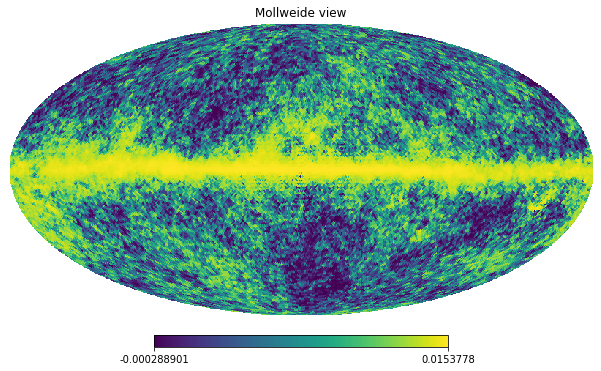

In [92]:
hp.mollview(maps[0], norm="hist")

let's try to subtract to that the input maps, integrated in band like the tod:

In [93]:
int_maps = np.zeros_like(hwp_sys_band.maps)
for i in range(int_maps.shape[0]):
    int_maps[i] = hwp_sys_band.cmb2bb[i] * hwp_sys_band.maps[i]

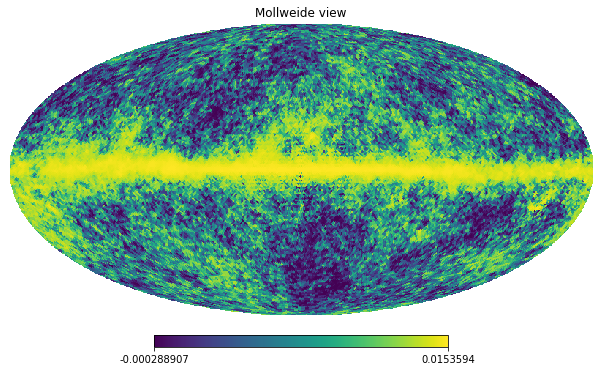

In [94]:
summed_maps = int_maps.sum(axis=0)
hp.mollview(summed_maps[0], norm="hist")

The difference between the output and the integral in frequency of band * input map is not null because of the chromaticity of FG and HWP+bandpass parameters coupled to the mapmaking procedure. The CMB contribution is perfectly canceled out

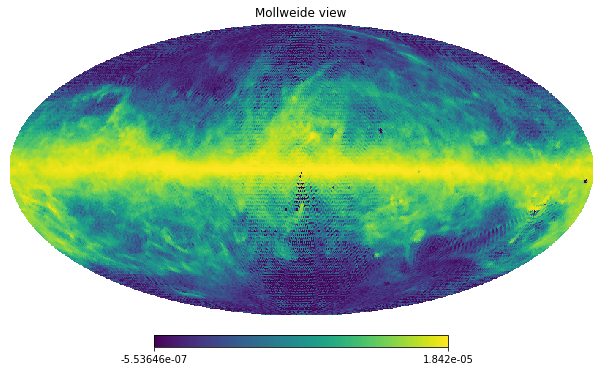

In [95]:
hp.mollview(maps[0] - summed_maps[0], norm="hist")

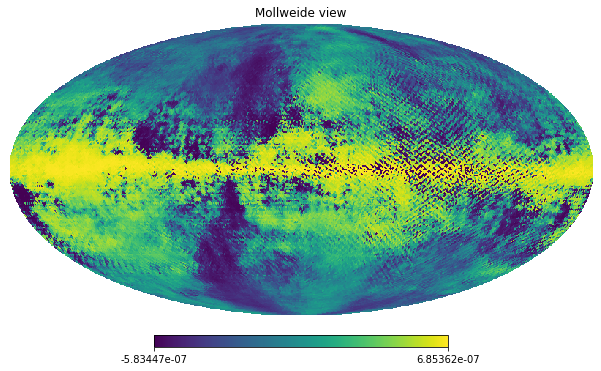

In [96]:
hp.mollview(maps[1] - summed_maps[1], norm="hist")

let's consider now a mismatch in the band between tod and solver:

In [102]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat-exp",
            "band_alpha": 0.9,
            "band_beta": 0.9,
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [103]:
(obs_m,) = sim.create_observations(detectors=dets)
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [104]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    correct_in_solver=True,
    integrate_in_band_solver=True,
    built_map_on_the_fly=True,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-26 11:05:12,533 WARNING MPI#0000] Apodizing w/ exp profile
[2022-10-26 11:05:12,534 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-26 11:05:12,535 INFO MPI#0000] generating and saving cmb simulations
[2022-10-26 11:05:12,546 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:12,546 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:12,561 INFO MPI#0000] NSIDE = 64
[2022-10-26 11:05:12,562 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 11:05:12,564 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 11:05:12,608 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:12,609 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:12,610 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:12,611 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:12,653 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:12,654 INFO MPI#0000] -> fwhm is 30.800000 

***************** D
***************** D
***************** D


[2022-10-26 11:05:12,791 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:12,792 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:12,793 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:12,794 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:12,834 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:12,835 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:12,836 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:12,837 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:12,873 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:12,873 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:12,875 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:12,875 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:12,915 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:12,916

[2022-10-26 11:05:13,941 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:13,942 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:13,985 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:13,985 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:13,986 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:13,987 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:14,025 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:14,026 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:14,028 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:14,029 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:14,062 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:14,063 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:14,064 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:14,066 

[2022-10-26 11:05:15,142 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:15,144 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:15,147 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:15,148 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:15,183 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:15,185 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:15,187 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:15,189 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:15,223 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:15,225 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:15,227 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:15,229 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:15,266 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:15,267

[2022-10-26 11:05:16,396 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:16,397 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:16,493 INFO MPI#0000] generating and saving fg simulations
[2022-10-26 11:05:16,497 INFO MPI#0000] NSIDE = 512
[2022-10-26 11:05:16,498 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 11:05:16,500 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 11:05:16,623 INFO MPI#0000] NSIDE = 512
[2022-10-26 11:05:16,625 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 11:05:16,627 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 11:05:16,748 INFO MPI#0000] NSIDE = 512
[2022-10-26 11:05:16,750 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 11:05:16,752 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 11:05:16,874 INFO MPI#0000] NSIDE = 512
[2022-10-26 11:05:16,876 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-26 11:05:16,877 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-26 11:05:17,136 INFO MPI#0000] Sigma is 13

[2022-10-26 11:05:21,453 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:21,454 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:21,633 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:21,634 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:21,635 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:21,635 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:21,899 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:21,899 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:21,900 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:21,901 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:22,137 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:22,138 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:22,139 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:22,140 

[2022-10-26 11:05:26,672 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:26,674 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:26,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:26,678 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:26,840 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:26,842 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:26,844 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:26,846 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:27,023 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:27,025 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:27,027 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:27,030 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:27,183 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:27,185

[2022-10-26 11:05:31,029 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:31,037 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:31,190 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:31,195 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:31,202 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:31,205 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:31,358 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:31,365 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:31,368 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:31,370 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:31,532 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:31,534 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:31,537 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:31,539 

[2022-10-26 11:05:34,532 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:34,534 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:34,638 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:34,639 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:34,642 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:34,645 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:34,751 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:34,753 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:34,756 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:34,758 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:34,861 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:34,863 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:34,866 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:34,868 

[2022-10-26 11:05:37,722 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:37,724 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:37,726 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:37,728 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:37,835 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:37,837 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:37,839 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:37,841 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:37,945 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:37,947 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:37,949 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:37,951 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:38,051 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:38,053

[2022-10-26 11:05:40,824 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:40,826 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:40,935 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:40,937 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:40,939 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:40,941 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:41,044 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:41,046 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:41,048 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:41,050 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:41,160 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:41,162 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:41,164 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:41,166 

[2022-10-26 11:05:46,108 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:46,110 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:46,113 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:46,115 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:46,353 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:46,355 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:46,357 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:46,359 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:46,596 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:46,598 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:46,600 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:46,602 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:46,848 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:46,850

[2022-10-26 11:05:52,614 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:52,616 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:52,954 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:52,956 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:52,958 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:52,960 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:53,209 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:53,215 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:53,218 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:53,219 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:05:53,482 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:53,484 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:53,486 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:53,488 

[2022-10-26 11:05:59,944 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:05:59,951 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:05:59,958 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:05:59,960 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:00,196 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:00,202 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:00,206 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:00,207 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:00,454 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:00,456 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:00,459 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:00,462 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:00,705 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:00,707

[2022-10-26 11:06:06,216 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:06,402 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:06,403 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:06,405 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:06,406 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:06,561 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:06,563 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:06,565 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:06,567 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:06,775 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:06,781 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:06,789 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:06,792 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:06,962 INFO MPI#0000]

[2022-10-26 11:06:10,051 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:10,054 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:10,055 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:10,124 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:10,125 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:10,128 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:10,130 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:10,194 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:10,196 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:10,198 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:10,200 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:10,261 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:10,263 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:10,265 INFO MPI#0000

[2022-10-26 11:06:12,429 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:12,490 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:12,492 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:12,494 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:12,496 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:12,559 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:12,561 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:12,563 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:12,565 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:12,623 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-26 11:06:12,625 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-26 11:06:12,627 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-26 11:06:12,629 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-26 11:06:12,689 INFO MPI#0000]

In [105]:
hwp_sys_band.fill_tod(obs = obs_m, pointings = pointings, hwp_radpsec = hwp_radpsec)

In [106]:
maps_mism = hwp_sys_band.make_map([obs_m])

In [107]:
int_maps_solver = np.zeros_like(hwp_sys_band.maps)
for i in range(int_maps.shape[0]):
    int_maps_solver = hwp_sys_band.cmb2bb_solver[i] * hwp_sys_band.maps[i]
summed_maps_solver = int_maps_solver.sum(axis=0)

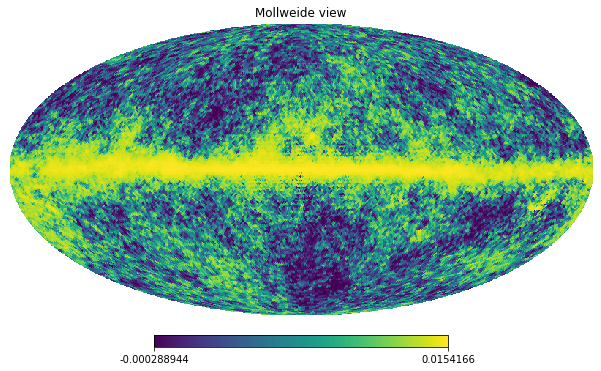

In [109]:
hp.mollview(maps_mism[0] - summed_maps_solver[0], norm="hist")

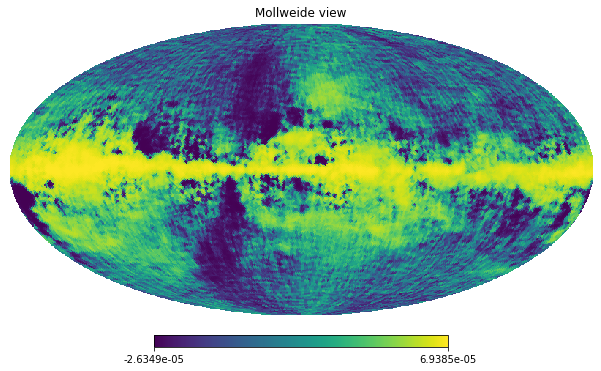

In [110]:
hp.mollview(maps_mism[1] - summed_maps_solver[1], norm="hist")

we see that we have a residual of CMB in those maps, due to the bandpass mismatch. Let's try and derive the spectra of those residual maps

In [111]:
res_nomism = maps - summed_maps
res_mism = maps_mism - summed_maps_solver

In [112]:
cl_nomism = hp.anafast(res_nomism) * 1e12
cl_mism = hp.anafast(res_mism) * 1e12
ell = np.arange(cl_mism.shape[1])

Text(0.5, 1.0, 'Power spectra of residuals')

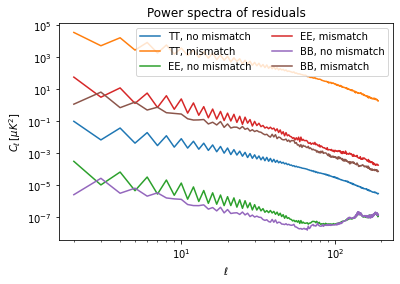

In [113]:
plt.loglog(ell[2:], cl_nomism[0, 2:], label="TT, no mismatch")
plt.loglog(ell[2:], cl_mism[0, 2:], label="TT, mismatch")
plt.loglog(ell[2:], cl_nomism[1, 2:], label="EE, no mismatch")
plt.loglog(ell[2:], cl_mism[1, 2:], label="EE, mismatch")
plt.loglog(ell[2:], cl_nomism[2, 2:], label="BB, no mismatch")
plt.loglog(ell[2:], cl_mism[2, 2:], label="BB, mismatch")
plt.legend(ncol=2, loc="upper right")
plt.ylabel(r"$C_{\ell} \, [\mu K^2]$")
plt.xlabel("$\ell$")
plt.title("Power spectra of residuals")

The residual maps are not masked so the main contribution in all cases comes from the galactic plane.
According to eq. 38 of https://arxiv.org/abs/2106.08031v3, using the integral in frequency of the input maps is not the best way to minimize the residual maps and to make it dependent just on the mismatch between the bandpasses and the HWP parameters in the tod and the solver. The firs map we have done can act as a template map, having bandpass_tod = bandpass_solver and the same bandpass solver as the second map

Text(0.5, 1.0, 'Power spectra of residuals')

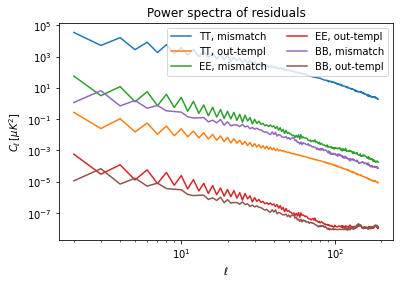

In [116]:
cl_res = hp.anafast(maps_mism - maps) * 1e12
plt.loglog(ell[2:],cl_mism[0,2:],label = 'TT, mismatch')
plt.loglog(ell[2:], cl_res[0, 2:], label="TT, out-templ")
plt.loglog(ell[2:],cl_mism[1,2:],label = 'EE, mismatch')
plt.loglog(ell[2:], cl_res[1, 2:], label="EE, out-templ")
plt.loglog(ell[2:],cl_mism[2,2:],label = 'BB, mismatch')
plt.loglog(ell[2:], cl_res[2, 2:], label="BB, out-templ")
plt.legend(ncol=2, loc="upper right")
plt.ylabel(r"$C_{\ell} \, [\mu K^2]$")
plt.xlabel("$\ell$")
plt.title("Power spectra of residuals")